In [ ]:
import os
import sys
import time
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.io
from scipy.interpolate import griddata
from pyDOE import lhs

import torch
import torch.nn as nn
import torch.optim as optim


torch.manual_seed(1234)
np.random.seed(1234)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\033[91mUsing device: {device}\033[0m")
time.sleep(2)

Using device: cuda


In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, layers):
        super(NeuralNetwork, self).__init__()
        
        
        self.depth = len(layers) - 1
        
       
        self.activation = nn.Tanh()
        
        
        layer_list = []
        for i in range(self.depth):
            layer_list.append(nn.Linear(layers[i], layers[i+1]))
            
            
            nn.init.xavier_normal_(layer_list[i].weight)
            nn.init.zeros_(layer_list[i].bias)
            
        self.layers = nn.ModuleList(layer_list)
    
    def forward(self, x):
        for i in range(self.depth - 1):
            x = self.activation(self.layers[i](x))
        
       
        x = self.layers[-1](x)
        return x

In [ ]:
class PhysicsInformedNN:
    def __init__(self, x0, u0, v0, tb, X_f, layers, lb, ub, X_u_train):
        
        
        self.x0 = torch.tensor(x0, dtype=torch.float32).to(device)
        self.t0 = torch.tensor(np.zeros_like(x0), dtype=torch.float32).to(device)
        self.u0 = torch.tensor(u0, dtype=torch.float32).to(device)
        self.v0 = torch.tensor(v0, dtype=torch.float32).to(device)
        
       
        self.x_lb = torch.tensor(lb[0] * np.ones_like(tb), dtype=torch.float32).to(device)
        self.t_lb = torch.tensor(tb, dtype=torch.float32).to(device)
        
        self.x_ub = torch.tensor(ub[0] * np.ones_like(tb), dtype=torch.float32).to(device)
        self.t_ub = torch.tensor(tb, dtype=torch.float32).to(device)
        
      
        self.x_f = torch.tensor(X_f[:, 0:1], dtype=torch.float32).to(device)
        self.t_f = torch.tensor(X_f[:, 1:2], dtype=torch.float32).to(device)
       
        self.lb = torch.tensor(lb, dtype=torch.float32).to(device)
        self.ub = torch.tensor(ub, dtype=torch.float32).to(device)
        
        
        self.X_u_train = X_u_train
        
        
        self.layers = layers
        self.model = NeuralNetwork(layers).to(device)
        
       
        self.optimizer_adam = optim.Adam(self.model.parameters(), lr=0.001)
        self.optimizer_lbfgs = optim.LBFGS(
            self.model.parameters(), 
            max_iter=20000, 
            max_eval=20000, 
            history_size=50, 
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps, 
            line_search_fn="strong_wolfe"
        )
        
        
        self.loss_adam = []
        self.loss_lbfgs = []
        self.iteration = 0
    
    def net_uv(self, x, t):
       
        X = torch.cat([x, t], dim=1)
        X_normalized = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        
      
        uv = self.model(X_normalized)
        u, v = uv[:, 0:1], uv[:, 1:2]
        
        return u, v
    
    def net_f_uv(self, x, t):
        x = x.clone().detach().requires_grad_(True)
        t = t.clone().detach().requires_grad_(True)
        
       
        u, v = self.net_uv(x, t)
        
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        
        u_x = torch.autograd.grad(
            u, x,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        
        u_xx = torch.autograd.grad(
            u_x, x,
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        v_t = torch.autograd.grad(
            v, t,
            grad_outputs=torch.ones_like(v),
            retain_graph=True,
            create_graph=True
        )[0]
        
        v_x = torch.autograd.grad(
            v, x,
            grad_outputs=torch.ones_like(v),
            retain_graph=True,
            create_graph=True
        )[0]
        
        v_xx = torch.autograd.grad(
            v_x, x,
            grad_outputs=torch.ones_like(v_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
     
        f_u = u_t + 0.5*v_xx + (u**2 + v**2)*v
        f_v = v_t - 0.5*u_xx - (u**2 + v**2)*u
        
        return f_u, f_v
    
    def loss_fn(self):
        
        u_pred0, v_pred0 = self.net_uv(self.x0, self.t0)
        loss_u0 = torch.mean((self.u0 - u_pred0)**2)
        loss_v0 = torch.mean((self.v0 - v_pred0)**2)
        
        
        u_lb, v_lb = self.net_uv(self.x_lb, self.t_lb)
        
        
        u_ub, v_ub = self.net_uv(self.x_ub, self.t_ub)
        
        
        loss_u_bnd = torch.mean((u_lb - u_ub)**2)
        loss_v_bnd = torch.mean((v_lb - v_ub)**2)
        
        
        x_lb = self.x_lb.clone().detach().requires_grad_(True)
        t_lb = self.t_lb.clone().detach().requires_grad_(True)
        u_lb, v_lb = self.net_uv(x_lb, t_lb)
        
        u_x_lb = torch.autograd.grad(
            u_lb, x_lb,
            grad_outputs=torch.ones_like(u_lb),
            retain_graph=True,
            create_graph=True
        )[0]
        
        v_x_lb = torch.autograd.grad(
            v_lb, x_lb,
            grad_outputs=torch.ones_like(v_lb),
            retain_graph=True,
            create_graph=True
        )[0]
        
        x_ub = self.x_ub.clone().detach().requires_grad_(True)
        t_ub = self.t_ub.clone().detach().requires_grad_(True)
        u_ub, v_ub = self.net_uv(x_ub, t_ub)
        
        u_x_ub = torch.autograd.grad(
            u_ub, x_ub,
            grad_outputs=torch.ones_like(u_ub),
            retain_graph=True,
            create_graph=True
        )[0]
        
        v_x_ub = torch.autograd.grad(
            v_ub, x_ub,
            grad_outputs=torch.ones_like(v_ub),
            retain_graph=True,
            create_graph=True
        )[0]
        
        loss_u_x_bnd = torch.mean((u_x_lb - u_x_ub)**2)
        loss_v_x_bnd = torch.mean((v_x_lb - v_x_ub)**2)
        
       
        f_u, f_v = self.net_f_uv(self.x_f, self.t_f)
        loss_f_u = torch.mean(f_u**2)
        loss_f_v = torch.mean(f_v**2)
        
      
        loss = loss_u0 + loss_v0 + \
               loss_u_bnd + loss_v_bnd + \
               loss_u_x_bnd + loss_v_x_bnd + \
               loss_f_u + loss_f_v
        
        return loss
    
    def closure(self):
        self.optimizer_lbfgs.zero_grad()
        loss = self.loss_fn()
        loss.backward()
        self.iteration += 1
        if self.iteration % 100 == 0:
            print(f'Iteration {self.iteration}: Loss L-BFGS = {loss.item():.5e}')
        self.loss_lbfgs.append(loss.item())
        return loss
    
    def train(self, epochs):
        self.model.train()
        
        # First train with Adam
        start_time = time.time()
        for epoch in range(epochs):
            self.optimizer_adam.zero_grad()
            loss = self.loss_fn()
            loss.backward()
            self.optimizer_adam.step()
            
            self.loss_adam.append(loss.item())
            
            if epoch % 100 == 0:
                elapsed = time.time() - start_time
                print(f'Epoch {epoch}, Loss Adam: {loss.item():.5e}, Time: {elapsed:.2f}s')
                start_time = time.time()
        
        print('Finished Adam optimization. Starting L-BFGS...')
        
        # Then refine with L-BFGS
        self.iteration = 0
        self.optimizer_lbfgs.step(self.closure)
        
        print('Done!')
    
    def predict(self, X_star):
        self.model.eval()
        
        x = torch.tensor(X_star[:, 0:1], dtype=torch.float32).to(device)
        t = torch.tensor(X_star[:, 1:2], dtype=torch.float32).to(device)
        
        with torch.no_grad():
            u, v = self.net_uv(x, t)
        
        x_f = torch.tensor(X_star[:, 0:1], dtype=torch.float32).to(device).requires_grad_(True)
        t_f = torch.tensor(X_star[:, 1:2], dtype=torch.float32).to(device).requires_grad_(True)
        
        with torch.no_grad():
            f_u, f_v = self.net_f_uv(x_f, t_f)
        
        return u.cpu().numpy(), v.cpu().numpy(), f_u.cpu().numpy(), f_v.cpu().numpy()

In [ ]:

try:
    data = scipy.io.loadmat('NLS_2soliton_interaction.mat')
    print("Data loaded successfully!")
except:
    print("Error loading data file. Make sure 'NLS_2soliton_interaction.mat' is in the current directory.")
   


t = data['t_values'].flatten()[:, None]
x = data['x_values'].flatten()[:, None]
Exact = data['q_values']

Exact_u = np.real(Exact)
Exact_v = np.imag(Exact)
Exact_h = np.sqrt(Exact_u ** 2 + Exact_v ** 2)


X, T = np.meshgrid(x, t)
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
u_star = Exact_u.T.flatten()[:, None]
v_star = Exact_v.T.flatten()[:, None]
h_star = Exact_h.T.flatten()[:, None]

Data loaded successfully!


In [ ]:

lb = np.array([0.0, 0.0])  
ub = np.array([20.0, 5.0])  


N0 = 100     # Points for initial condition
N_b = 100    # Points for boundary condition
N_f = 20000  # Collocation points


layers = [2, 80, 80, 80, 80, 2]  


idx_x = np.random.choice(x.shape[0], N0, replace=False)
x0 = x[idx_x, :]
u0 = Exact_u[idx_x, 0:1]
v0 = Exact_v[idx_x, 0:1]


idx_t = np.random.choice(t.shape[0], N_b, replace=False)
tb = t[idx_t, :]

X_f = lb + (ub - lb) * lhs(2, N_f)


X0 = np.concatenate((x0, 0 * x0), 1)  # (x0, 0)
X_lb = np.concatenate((0 * tb + lb[0], tb), 1)  # (lb[0], tb)
X_ub = np.concatenate((0 * tb + ub[0], tb), 1)  # (ub[0], tb)
X_u_train = np.vstack([X0, X_lb, X_ub])

In [ ]:

model = PhysicsInformedNN(x0, u0, v0, tb, X_f, layers, lb, ub, X_u_train)

start_time = time.time()
model.train(epochs=5000)  
elapsed = time.time() - start_time
print(f'Training time: {elapsed:.4f} seconds')

Epoch 0, Loss Adam: 3.57202e-01, Time: 0.49s
Epoch 100, Loss Adam: 1.86055e-01, Time: 1.98s
Epoch 100, Loss Adam: 1.86055e-01, Time: 1.98s
Epoch 200, Loss Adam: 1.85741e-01, Time: 2.00s
Epoch 200, Loss Adam: 1.85741e-01, Time: 2.00s
Epoch 300, Loss Adam: 1.85603e-01, Time: 1.99s
Epoch 300, Loss Adam: 1.85603e-01, Time: 1.99s
Epoch 400, Loss Adam: 1.85381e-01, Time: 2.07s
Epoch 400, Loss Adam: 1.85381e-01, Time: 2.07s
Epoch 500, Loss Adam: 1.86864e-01, Time: 2.03s
Epoch 500, Loss Adam: 1.86864e-01, Time: 2.03s
Epoch 600, Loss Adam: 1.86267e-01, Time: 2.12s
Epoch 600, Loss Adam: 1.86267e-01, Time: 2.12s
Epoch 700, Loss Adam: 1.83435e-01, Time: 2.21s
Epoch 700, Loss Adam: 1.83435e-01, Time: 2.21s
Epoch 800, Loss Adam: 1.83192e-01, Time: 2.05s
Epoch 800, Loss Adam: 1.83192e-01, Time: 2.05s
Epoch 900, Loss Adam: 1.82868e-01, Time: 1.89s
Epoch 900, Loss Adam: 1.82868e-01, Time: 1.89s
Epoch 1000, Loss Adam: 1.82249e-01, Time: 1.88s
Epoch 1000, Loss Adam: 1.82249e-01, Time: 1.88s
Epoch 1100, L

In [ ]:

x_star = torch.tensor(X_star[:, 0:1], dtype=torch.float32).to(device)
t_star = torch.tensor(X_star[:, 1:2], dtype=torch.float32).to(device)
with torch.no_grad():
    u_pred_t, v_pred_t = model.net_uv(x_star, t_star)


u_pred = u_pred_t.cpu().numpy()
v_pred = v_pred_t.cpu().numpy()


x_f = torch.tensor(X_star[:, 0:1], dtype=torch.float32).to(device).requires_grad_(True)
t_f = torch.tensor(X_star[:, 1:2], dtype=torch.float32).to(device).requires_grad_(True)

f_u_pred_t, f_v_pred_t = model.net_f_uv(x_f, t_f)


f_u_pred = f_u_pred_t.detach().cpu().numpy()
f_v_pred = f_v_pred_t.detach().cpu().numpy()


h_pred = np.sqrt(u_pred ** 2 + v_pred ** 2)


error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
error_v = np.linalg.norm(v_star - v_pred, 2) / np.linalg.norm(v_star, 2)
error_h = np.linalg.norm(h_star - h_pred, 2) / np.linalg.norm(h_star, 2)

print(f'Error u: {error_u:.3e}')
print(f'Error v: {error_v:.3e}')
print(f'Error h: {error_h:.3e}')


U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
V_pred = griddata(X_star, v_pred.flatten(), (X, T), method='cubic')
H_pred = griddata(X_star, h_pred.flatten(), (X, T), method='cubic')

U_star = griddata(X_star, u_star.flatten(), (X, T), method='cubic')
V_star = griddata(X_star, v_star.flatten(), (X, T), method='cubic')
H_star = griddata(X_star, h_star.flatten(), (X, T), method='cubic')

FU_pred = griddata(X_star, f_u_pred.flatten(), (X, T), method='cubic')
FV_pred = griddata(X_star, f_v_pred.flatten(), (X, T), method='cubic')

Error u: 1.259e-02
Error v: 1.415e-02
Error h: 9.215e-03


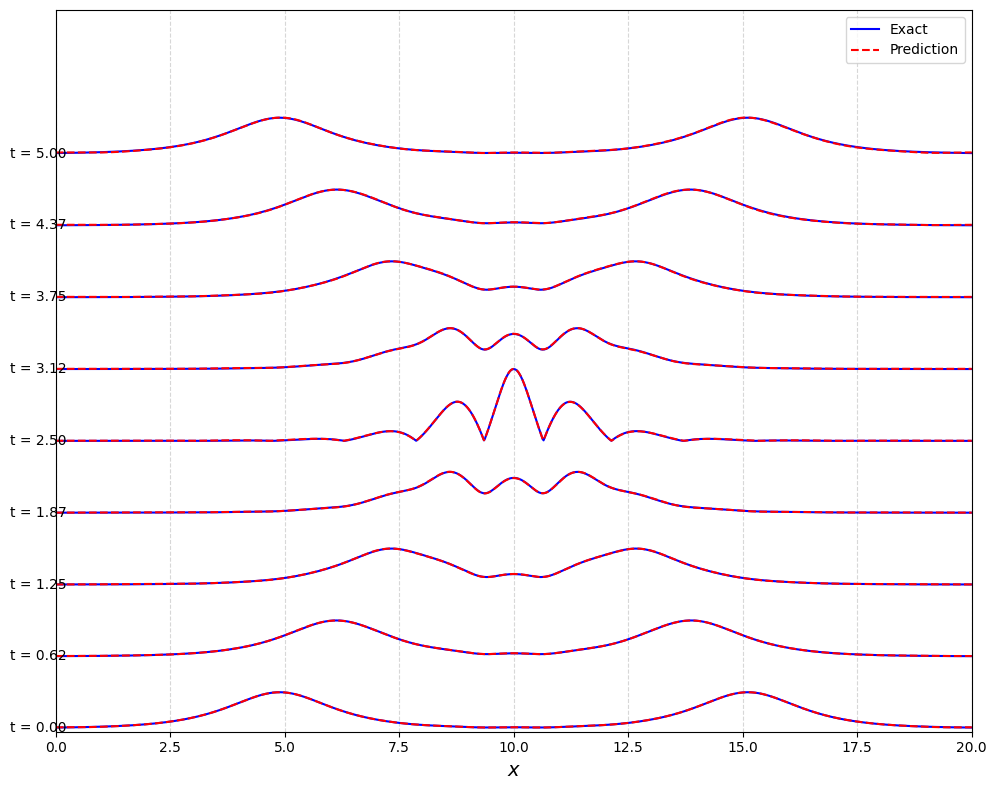

In [ ]:

plt.figure(figsize=(10, 8))
x_min, x_max = x.min(), x.max()
cut_indices = np.linspace(0, len(t) - 1, 9, dtype=int)
y_min, y_max = -0.1, (len(cut_indices) + 1) * 2.0

for i, idx in enumerate(cut_indices):
    vertical_offset = i * 2.0  
    plt.plot(x, Exact_h[:, idx] + vertical_offset, 'b-', linewidth=1.5, label=f't = {t[idx, 0]:.2f}' if i == 0 else "")
    plt.plot(x, H_pred[idx, :] + vertical_offset, 'r--', linewidth=1.5)
    plt.text(x_min - 1, vertical_offset, f't = {t[idx, 0]:.2f}', fontsize=10, verticalalignment='center')

plt.xlabel('$x$', fontsize=14)
plt.ylabel('')
plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max])
plt.gca().set_yticks([])
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(['Exact', 'Prediction'], loc='upper right', fontsize=10)
plt.tight_layout()
plt.savefig('time_slices_pytorch.pdf', dpi=300)
plt.show()

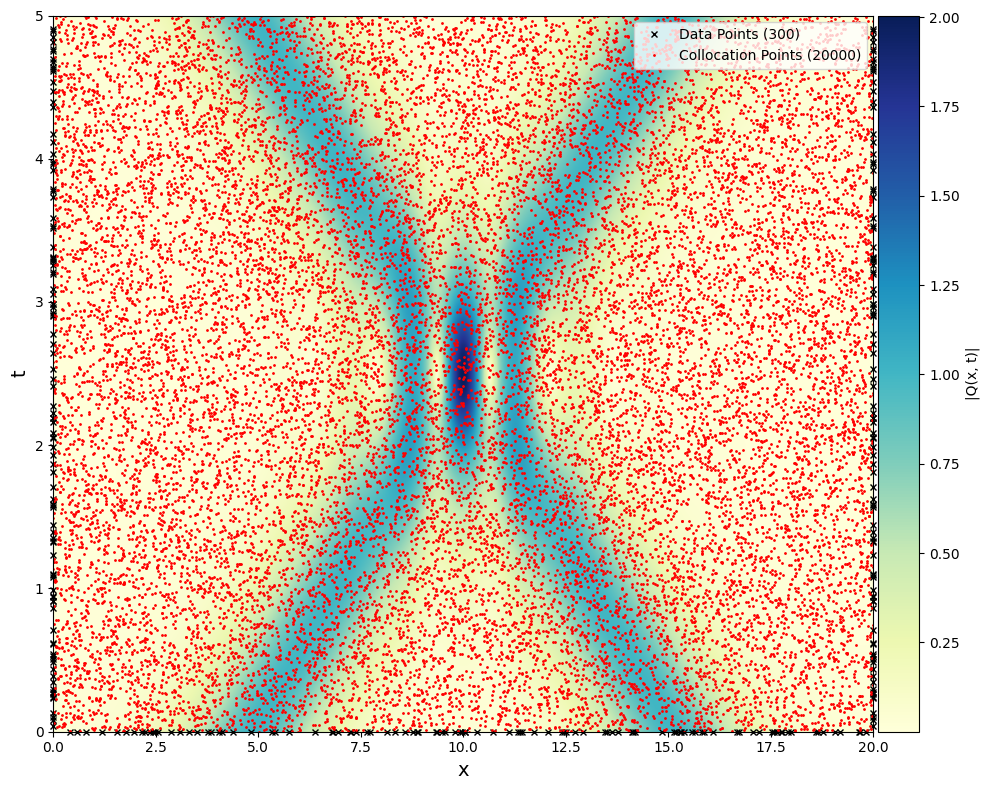

In [ ]:

fig, ax = plt.subplots(figsize=(10, 8))


h_img = ax.imshow(H_pred,
                  extent=[lb[0], ub[0], lb[1], ub[1]],  # [x_min, x_max, t_min, t_max]
                  origin='lower',
                  aspect='auto',
                  cmap='YlGnBu')
                  
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h_img, cax=cax, label='|Q(x, t)|')


ax.plot(X_u_train[:, 0], X_u_train[:, 1],
        'kx', label=f'Data Points ({X_u_train.shape[0]})',
        markersize=4, clip_on=False)
ax.plot(X_f[:, 0], X_f[:, 1],
        'r.', label=f'Collocation Points ({X_f.shape[0]})',
        markersize=2)
ax.legend(loc='upper right', fontsize=10, framealpha=0.8)
ax.set_xlabel("x", fontsize=14)
ax.set_ylabel("t", fontsize=14)
plt.tight_layout()
plt.savefig('data_distribution_pytorch.pdf', dpi=150)
plt.show()

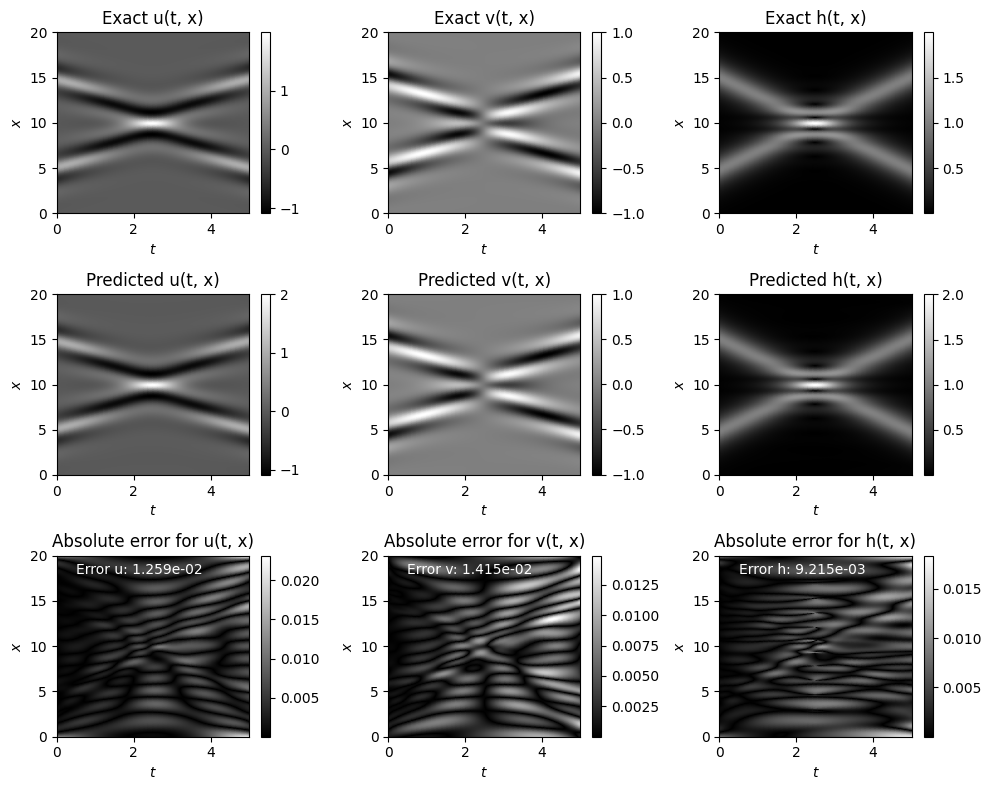

In [ ]:

plt.figure(figsize=(10, 8))

# Plotting exact u(t, x)
plt.subplot(3, 3, 1)
plt.pcolor(T, X, U_star, cmap='gray')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Exact u(t, x)')
plt.tight_layout()


plt.subplot(3, 3, 2)
plt.pcolor(T, X, V_star, cmap='gray')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Exact v(t, x)')
plt.tight_layout()


plt.subplot(3, 3, 3)
plt.pcolor(T, X, H_star, cmap='gray')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Exact h(t, x)')
plt.tight_layout()


plt.subplot(3, 3, 4)
plt.pcolor(T, X, U_pred, cmap='gray')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Predicted u(t, x)')
plt.tight_layout()


plt.subplot(3, 3, 5)
plt.pcolor(T, X, V_pred, cmap='gray')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Predicted v(t, x)')
plt.tight_layout()


plt.subplot(3, 3, 6)
plt.pcolor(T, X, H_pred, cmap='gray')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Predicted h(t, x)')
plt.tight_layout()


plt.subplot(3, 3, 7)
plt.pcolor(T, X, np.abs(U_star - U_pred), cmap='gray')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Absolute error for u(t, x)')
plt.text(0.1, 0.9, f'Error u: {error_u:.3e}', color='white', fontsize=10, transform=plt.gca().transAxes)
plt.tight_layout()


plt.subplot(3, 3, 8)
plt.pcolor(T, X, np.abs(V_star - V_pred), cmap='gray')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Absolute error for v(t, x)')
plt.text(0.1, 0.9, f'Error v: {error_v:.3e}', color='white', fontsize=10, transform=plt.gca().transAxes)
plt.tight_layout()

plt.subplot(3, 3, 9)
plt.pcolor(T, X, np.abs(H_star - H_pred), cmap='gray')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Absolute error for h(t, x)')
plt.text(0.1, 0.9, f'Error h: {error_h:.3e}', color='white', fontsize=10, transform=plt.gca().transAxes)
plt.tight_layout()
plt.savefig('U_V_H_errors_pytorch.pdf', dpi=150, bbox_inches='tight')
plt.show()

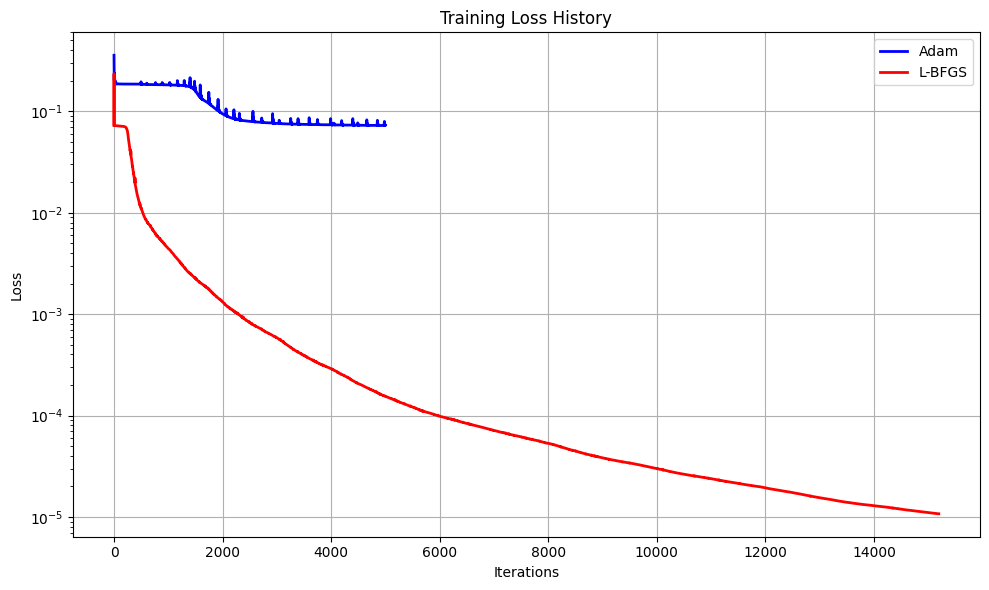

In [ ]:

plt.figure(figsize=(10, 6))


if len(model.loss_adam) > 0:
    plt.semilogy(range(len(model.loss_adam)), model.loss_adam, 'b-', linewidth=2, label='Adam')


if len(model.loss_lbfgs) > 0:
    plt.semilogy(range(len(model.loss_lbfgs)), model.loss_lbfgs, 'r-', linewidth=2, label='L-BFGS')

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('loss_history_pytorch.pdf', dpi=150)
plt.show()

In [ ]:

np.savez_compressed('PINN_results_pytorch.npz',
     x=X[0, :],                  # x-axis
     t=T[:, 0],                  # t-axis
     X=X,
     T=T,
     Exact_h = Exact_h,
     U_star=U_star,
     V_star=V_star,
     H_star=H_star,
     U_pred=U_pred,
     V_pred=V_pred,
     H_pred=H_pred,
     X_u_train=X_u_train,
     X_f=X_f,
     lb=lb,
     ub=ub,
     error_u=error_u,
     error_v=error_v,
     error_h=error_h
)


metadata = {
     'layers': layers,
     'N0': int(N0),
     'Nb': int(N_b),
     'Nf': int(N_f),
     'lb': lb.tolist(),
     'ub': ub.tolist(),
     'error_u': float(error_u),
     'error_v': float(error_v),
     'error_h': float(error_h),
     'training_time_sec': float(elapsed),
     'framework': 'PyTorch',
     'device': str(device)
}

with open('PINN_metadata_pytorch.json', 'w') as f:
    json.dump(metadata, f, indent=4)

In [ ]:

import pandas as pd
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter

print("\n" + "="*70)
print("COMPARATIVA DE FRAMEWORKS - NLS con Interacción de 2 Solitones")
print("Arquitectura: [2, 80, 80, 80, 80, 2]")
print("="*70 + "\n")


comparison_data = {
    'Framework': ['TensorFlow 1', 'PyTorch', 'PyTorch Optimizado'],
    'Error u': ['1.021e-02', '1.979e-02', '1.259e-02'],
    'Error v': ['1.175e-02', '2.402e-02', '1.415e-02'],
    'Error h': ['7.299e-03', '1.046e-02', '9.215e-03'],
    'Tiempo (s)': [1723.09, 2565.47, 561.31]
}

df_comparison = pd.DataFrame(comparison_data)
print(df_comparison.to_string(index=False))
print("\n" + "="*70)
print("Análisis:")
print("- TensorFlow 1: Mejor precisión en error h (7.299e-03) pero tiempo alto (1723s)")
print("- PyTorch Optimizado: Mejor balance velocidad/precisión (561s, 3x más rápido)")
print("- PyTorch estándar: Tiempo más alto (2565s) con errores intermedios")
print("="*70 + "\n")


print("Generando animación de la evolución...")

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlim(x.min(), x.max())
ax.set_ylim(-0.1, 2.5)
ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('|q(x,t)|', fontsize=14)
ax.grid(True, alpha=0.3)

line_exact, = ax.plot([], [], 'b-', linewidth=2, label='Exact')
line_pred, = ax.plot([], [], 'r--', linewidth=2, label='PINN')
ax.legend(loc='upper right', fontsize=12)
title = ax.text(0.5, 1.05, '', transform=ax.transAxes, ha='center', fontsize=16, weight='bold')

def init():
    line_exact.set_data([], [])
    line_pred.set_data([], [])
    return line_exact, line_pred, title

def animate(frame):
    line_exact.set_data(x.flatten(), Exact_h[:, frame])
    line_pred.set_data(x.flatten(), H_pred[frame, :])
    title.set_text(f'Evolución |q(x,t={t[frame, 0]:.2f})|')
    return line_exact, line_pred, title

anim = animation.FuncAnimation(fig, animate, init_func=init, 
                              frames=len(t), interval=50, blit=True, repeat=True)


writer = PillowWriter(fps=20)
anim.save('nlse_evolution.gif', writer=writer, dpi=100)
print("✓ Animación guardada como 'nlse_evolution.gif'")
plt.close()

plt.figure(figsize=(12, 6))
frame_idx = len(t) // 2
plt.plot(x, Exact_h[:, frame_idx], 'b-', linewidth=2, label='Exact')
plt.plot(x, H_pred[frame_idx, :], 'r--', linewidth=2, label='PINN Prediction')
plt.xlabel('x', fontsize=14)
plt.ylabel('|q(x,t)|', fontsize=14)
plt.title(f'Comparación en t={t[frame_idx, 0]:.2f}', fontsize=16, weight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('nlse_comparison_frame.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Todos los resultados han sido generados exitosamente.")